In [488]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KernelDensity
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

from utilities import evaluation

import matplotlib.pyplot as plt
import time
from scipy import sparse
import itertools
pd.options.display.float_format = "{:,.4f}".format

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
X = sparse.load_npz('data/train_steps_vec.npz')

In [9]:
X.shape[1]

17967

In [10]:
tfidf = TfidfTransformer()

In [11]:
T = tfidf.fit_transform(X)

In [13]:
test = sparse.load_npz('data/test_steps_vec.npz')

In [15]:
data = pd.read_csv("data/recipe_train.csv")

In [16]:
testingSet = pd.read_csv("data/recipe_test.csv")

In [18]:
y = data["duration_label"]

working on countvectoriser features

In [ ]:
%%time
## untuned
ingr_vec = sparse.load_npz('data/recipe_text_features_countvec/train_ingr_vec.npz').toarray()
name_vec = sparse.load_npz('data/recipe_text_features_countvec/train_name_vec.npz').toarray()
steps_vec = sparse.load_npz('data/recipe_text_features_countvec/train_steps_vec.npz').toarray()

X = np.hstack((ingr_vec, name_vec, steps_vec, data['n_ingredients'].to_numpy().reshape(-1,1),
              data['n_steps'].to_numpy().reshape(-1,1)))

del ingr_vec, name_vec, steps_vec

In [29]:
%%time
## untuned

f = SelectFdr(f_classif, alpha = 0.01)
X_f = f.fit_transform(X, y)
print(X_f.shape)

k = 100

mi = SelectKBest(mutual_info_classif, k = k)
X_f_mi = mi.fit_transform(X_f, y)
print(X_f_mi.shape)

rf = RandomForestClassifier()
print("RandomForest: ", cross_val_score(rf, X_f_mi, y, cv=5).mean())

lgb_model = lgb.LGBMClassifier()
print("lightGBM: ", cross_val_score(lgb_model, X_f_mi, y, cv = 5).mean())

(40000, 3053)
[[ 0.  0.  0. ...  0. 12.  6.]
 [ 0.  0.  1. ...  0.  5.  9.]
 [ 0.  1.  0. ...  0. 10. 15.]
 ...
 [ 0.  0.  0. ...  0.  8.  5.]
 [ 0.  1.  1. ...  1. 17.  7.]
 [ 0.  0.  1. ...  0. 11.  6.]]
RandomForest:  0.7985
lightGBM:  0.803725
Wall time: 16min 24s


In [107]:
%%time
## untuned
test_ingr_vec = sparse.load_npz('data/recipe_text_features_countvec/test_ingr_vec.npz').toarray()
test_name_vec = sparse.load_npz('data/recipe_text_features_countvec/test_name_vec.npz').toarray()
test_steps_vec = sparse.load_npz('data/recipe_text_features_countvec/test_steps_vec.npz').toarray()

test = np.hstack((test_ingr_vec, test_name_vec, test_steps_vec, testingSet['n_ingredients'].to_numpy().reshape(-1,1),
              testingSet['n_steps'].to_numpy().reshape(-1,1)))

del test_ingr_vec, test_name_vec, test_steps_vec

test = test.astype(np.float32)

test_f = f.transform(test)
print(test_f.shape)

k = 100

test_f_mi = mi.transform(test_f)
print(test_f_mi.shape)

(10000, 3053)
(10000, 100)
Wall time: 12.1 s


In [367]:
%%time
#tuning random forest
#rf_score = []
#r2_scores=[]
trees = range(100, 300, 10)
for n in trees:
    rf = RandomForestClassifier(n_estimators = n)
    #acc = cross_val_score(rf, X_f_vt_mi_mav, y, cv=5).mean()
    #print("RandomForest: ", acc)
    
    rf.fit(X_f_vt_mi_train_mav, y_train)
    
    r2_scores.append(r2_score(y_test, rf.predict(X_f_vt_mi_test_mav)))

Wall time: 4min 21s


In [317]:
rf_score

[0.692,
 0.7773249999999999,
 0.7906500000000001,
 0.7935749999999999,
 0.7964749999999999,
 0.797075,
 0.798025,
 0.799,
 0.7978500000000001,
 0.798525,
 0.7986249999999999,
 0.7998000000000001,
 0.7996999999999999,
 0.7987250000000001,
 0.79995,
 0.799025,
 0.8006,
 0.798875,
 0.800825,
 0.80055,
 0.80045,
 0.8006,
 0.80055,
 0.800025,
 0.79925,
 0.800075,
 0.8001249999999999,
 0.8009250000000001,
 0.800175,
 0.8008999999999998]

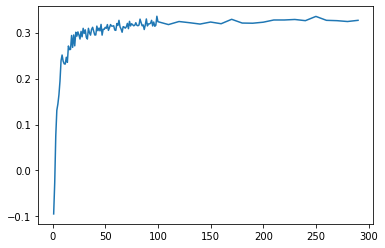

In [370]:
plt.plot([i for i in range(1, 100, 1)]+[i for i in range(100, 300, 10)], r2_scores)

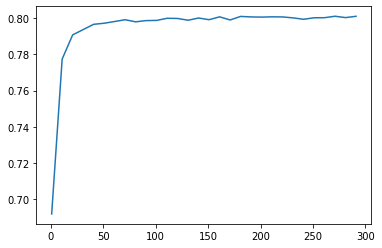

In [316]:
plt.plot(range(1, 300, 10), rf_score)

In [489]:
#tuned lgb

lgb_model = lgb.LGBMClassifier(max_depth = 10, num_leaves = 65)
#acc = cross_val_score(lgb_model, X_f_vt_mi_mav, y, cv = 5).mean()
#print("lightGBM: ", acc)
lgb_model.fit(X_f_vt_mi_train_mav, y_train)
print(evaluation.evaluate(lgb_model.predict(X_f_vt_mi_test_mav), y_test))

Accuracy = 80.92%
   Precision  Recall  F_score
1     0.7838  0.8287   0.8056
2     0.8326  0.8120   0.8222
3     0.8154  0.6090   0.6973

Confusion matrix:
      1     2    3
1  2918   581   22
2   734  3313   33
3    71    85  243

None


In [105]:
#tuned rc 0.78415
rc = RidgeClassifier(alpha = 20)
acc = cross_val_score(rc, X_f_mi, y, cv = 5).mean()
print("Ridge Regression: ", acc)

Ridge Regression:  0.7841000000000001


In [380]:
%%time
# tuning lgb
mn_score = []
#mn_score_train1 = []
#mn_score_test = []
for n in range(31, 200, 3):
    lgb_model = lgb.LGBMClassifier(max_depth = 10, num_leaves = n)
    #acc = cross_val_score(lgb_model, X_f_vt_mi_mav, y, cv = 5).mean()
    #print("lightGBM: ", acc)
    
    #lgb_model.fit(X_f_vt_mi_train_mav, y_train)
    #mn_score_train1.append(lgb_model.score(X_f_vt_mi_train_mav, y_train))
    mn_score_train.append(cross_val_score(lgb_model, X_f_vt_mi_mav, y, cv = 4).mean())
    #mn_score_test.append(lgb_model.score(X_f_vt_mi_test_mav, y_test))
    #mn_score.append(acc)

Wall time: 8min 27s


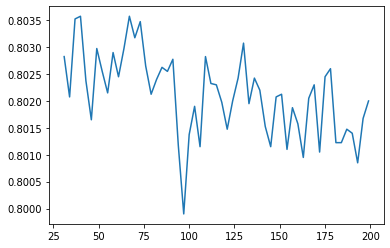

In [394]:
plt.plot(range(31, 200, 3), mn_score_train[-57:])

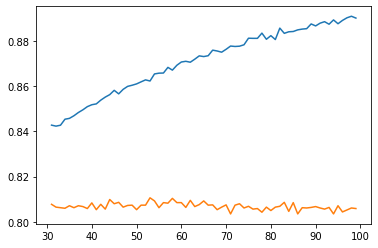

In [378]:
plt.plot(range(31, 100), mn_score_train1)
plt.plot(range(31, 100), mn_score_test)

In [98]:
rc1_score = []
for a in alpha_ridge:
    rc = RidgeClassifier(alpha = a)
    
    rc.fit(X_f_mi, y)
    acc = cross_val_score(rc,X_f_mi_train,y_train, cv = 5).mean()
    rc1_score.append(acc)

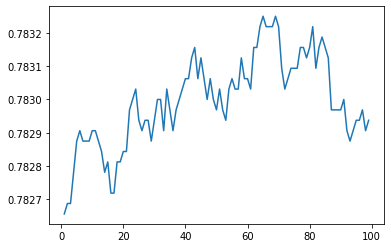

In [99]:
plt.plot(alpha_ridge, rc1_score)

In [427]:
%%time
#ridge regerssion
alpha_ridge =[1e-5, 1e-4, 1e-3,1e-2, 1e-1, 1,10, 100]
#[1e-5, 1e-4, 1e-3,1e-2, 1e-1, 1,10, 100]
rc_train = []
rc_test = []
mses = []
for a in alpha_ridge:
    rc = RidgeClassifier(alpha = a*0.1)

    #training and testing
    rc.fit(X_f_vt_mi_train_mav, y_train)
    acc = cross_val_score(rc,X_f_vt_mi_train_mav,y_train, cv = 5)
    print("Ridge Regerssion on countvectorser with f_classif feature select: ", acc)
    rc_train.append(acc.mean())
    acc = rc.score(X_f_vt_mi_test_mav, y_test)
    rc_test.append(acc)
    mse = mean_squared_error(y_test, rc.predict(X_f_vt_mi_test_mav))
    mses.append(mse)

Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78015625 0.78859375 0.78359375 0.78171875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78015625 0.78859375 0.78359375 0.78171875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78015625 0.78859375 0.78359375 0.78171875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78015625 0.78859375 0.78375    0.78171875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.78015625 0.78875    0.7840625  0.7815625 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7890625  0.780625   0.78859375 0.78421875 0.78203125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7890625  0.78046875 0.7875     0.78390625 0.78015625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7871875 0.77875   0.7875    0.7815625 0.7759375]
Wall time: 2.

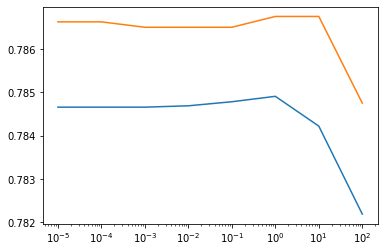

In [430]:
plt.plot(alpha_ridge, rc_train)
plt.plot(alpha_ridge, rc_test)
plt.xscale('log')

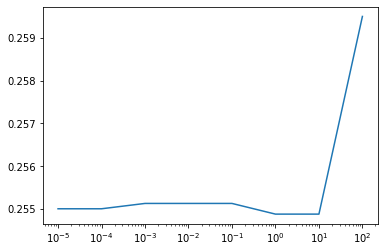

In [431]:
plt.plot(alpha_ridge, mses)
plt.xscale('log')

In [108]:
#0.804625 X_f_mi_train
%%time
estimators = [('rf', RandomForestClassifier(random_state=0)),
             ('rc', RidgeClassifierCV(alphas=[10, 14, 20, 23], cv = 5)),
             ('lgb', lgb.LGBMClassifier(max_depth = 10, num_leaves = 65))]

stacking = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())
stacking.fit(X_f_mi_train, y_train)
stacking.score(X_f_mi_test, y_test)
#stack_predicted = stacking.predict(test_vt_mav)
#stack_predicted

Wall time: 43.1 s


0.804625

In [495]:
%%time
#0.804625 with X_f_vt_mi_train 65
vt = VarianceThreshold(0.001)
X_f_vt = vt.fit_transform(X_f, y)
print(X_f_vt.shape)

(40000, 1764)
Wall time: 11.1 s


In [496]:
mi = SelectKBest(mutual_info_classif, k = 100)
X_f_vt_mi = mi.fit_transform(X_f_vt, y)
print(X_f_vt_mi.shape)

X_f_vt_mi_train, X_f_vt_mi_test, y_train, y_test = train_test_split(X_f_vt_mi, y, test_size=0.2, random_state=88)

(40000, 100)


In [497]:
mat = MaxAbsScaler()
X_f_vt_mi_mav = mat.fit_transform(X_f_vt_mi)
X_f_vt_mi_train_mav, X_f_vt_mi_test_mav, y_train, y_test = train_test_split(X_f_vt_mi_mav, y, test_size=0.2, random_state=88)

In [491]:
%%time
#0.804625 with X_f_vt_mi_train 65
#0.80375 63
#0.8035 62
#0.80375 59
#0.804625 53
#0.804375 52
#0.804875 new rc
#0.807625 with vt, 100 feature, new rc, 65
#0.808 with mav
rf = RandomForestClassifier(random_state=0)
rf.fit(X_f_vt_mi_mav, y)
print(evaluation.evaluate(rf.predict(test_f_vt_mi_mav), true))

rc = RidgeClassifierCV(alphas=[1, 3, 6, 10], cv = 5)
rc.fit(X_f_vt_mi_mav, y)
print(evaluation.evaluate(rc.predict(test_f_vt_mi_mav), true))

lgb_model = lgb.LGBMClassifier(max_depth = 10, num_leaves = 65)
lgb_model.fit(X_f_vt_mi_mav, y)
print(evaluation.evaluate(lgb_model.predict(test_f_vt_mi_mav), true))

estimators = [('rf', RandomForestClassifier(random_state=0)),
             ('rc', RidgeClassifierCV(alphas=[1, 3, 6, 10], cv = 5)),
             ('lgb', lgb.LGBMClassifier(max_depth = 10, num_leaves = 65))]

stacking = StackingClassifier(estimators = estimators, final_estimator = SGDClassifier(loss = 'log',max_iter=1000, tol=1e-3))
stacking.fit(X_f_vt_mi_mav, y)
print(evaluation.evaluate(rf.predict(test_f_vt_mi_mav), true))
#print(stacking.score(X_f_vt_mi_test_mav, y_test))
#print(precision_recall_fscore_support(y_test, stacking.predict(X_f_vt_mi_test_mav), average='micro'))

Accuracy = 80.50%
   Precision  Recall  F_score
1     0.7973  0.7996   0.7984
2     0.8055  0.8343   0.8197
3     0.9054  0.5639   0.6949

Confusion matrix:
      1     2    3
1  3579   881   16
2   817  4184   14
3    93   129  287

None
Accuracy = 78.70%
   Precision  Recall  F_score
1     0.7433  0.8450   0.7909
2     0.8289  0.7583   0.7920
3     0.8796  0.5599   0.6843

Confusion matrix:
      1     2    3
1  3782   680   14
2  1187  3803   25
3   119   105  285

None
Accuracy = 80.78%
   Precision  Recall  F_score
1     0.7826  0.8322   0.8066
2     0.8312  0.8034   0.8171
3     0.8244  0.6365   0.7184

Confusion matrix:
      1     2    3
1  3725   722   29
2   946  4029   40
3    89    96  324

None
Accuracy = 80.50%
   Precision  Recall  F_score
1     0.7973  0.7996   0.7984
2     0.8055  0.8343   0.8197
3     0.9054  0.5639   0.6949

Confusion matrix:
      1     2    3
1  3579   881   16
2   817  4184   14
3    93   129  287

None
Wall time: 1min 11s


In [357]:
%%time
#k_score = []
for k in [700, 600, 500, 400, 300, 200, 100]:
    mi = SelectKBest(mutual_info_classif, k = k)
    X_f_vt_mi = mi.fit_transform(X_f_vt_mi, y)
    print(X_f_vt_mi.shape)

    X_f_vt_mi_mav = mat.fit_transform(X_f_vt_mi)
    test_f_vt_mi = mi.transform(test_f_vt_mi)
    print(test_f_vt_mi.shape)
    test_f_vt_mi_mav = mat.transform(test_f_vt_mi)
    stacking.fit(X_f_vt_mi_mav, y)

    k_score.insert(0, (stacking.predict(test_f_vt_mi_mav) == true).sum())

(40000, 700)
(10000, 700)
(40000, 600)
(10000, 600)
(40000, 500)
(10000, 500)
(40000, 400)
(10000, 400)
(40000, 300)
(10000, 300)
(40000, 200)
(10000, 200)
(40000, 100)
(10000, 100)
Wall time: 31min 2s


In [358]:
k_score

[8122, 8133, 8124, 8126, 8138, 8153, 8162, 8184, 8143, 8160]

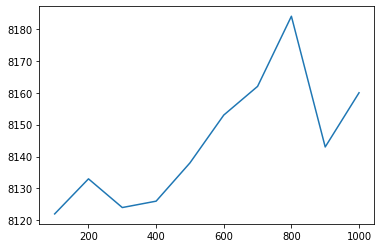

In [359]:
plt.plot(range(100, 1001, 100), k_score)

In [498]:
test_f_vt = vt.transform(test_f)
print(test_f_vt.shape)
test_f_vt_mi = mi.transform(test_f_vt)
print(test_f_vt_mi.shape)
test_f_vt_mi_mav = mat.transform(test_f_vt_mi)

(10000, 1764)
(10000, 100)


In [499]:
estimators = [('rf', RandomForestClassifier(random_state=0)),
             ('rc', RidgeClassifierCV(alphas=[1, 3, 6, 10], cv = 5)),
             ('lgb', lgb.LGBMClassifier(max_depth = 10, num_leaves = 65))]

stacking = StackingClassifier(estimators = estimators, final_estimator = SGDClassifier(loss = 'log',max_iter=1000, tol=1e-3))
#cross_val_score(stacking, X_f_vt_mi, y, cv = 4)
stacking.fit(X_f_vt_mi_mav, y)
#stacking.score(X_f_vt_mi_mav, y)
stack_predicted = stacking.predict(test_f_vt_mi_mav)
#stack_predicted

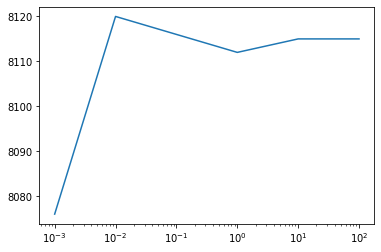

In [322]:
C = [0.001,0.01, 0.1, 1, 10, 100]
stack_score = []
for c in C:
    

    estimators = [('rf', RandomForestClassifier(random_state=0)),
                 ('rc', RidgeClassifierCV(alphas=[1, 3, 6, 10], cv = 5)),
                 ('lgb', lgb.LGBMClassifier(max_depth = 10, num_leaves = 65))]

    stacking = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(C=c,multi_class = 'multinomial'))
    #cross_val_score(stacking, X_f_vt_mi, y, cv = 4)
    stacking.fit(X_f_vt_mi_mav, y)
    #stacking.score(X_f_vt_mi_mav, y)
    stack_predicted = stacking.predict(test_f_vt_mi_mav)
    stack_score.append((stack_predicted== true).sum())
plt.plot(C, stack_score)
plt.xscale('log')

In [492]:
#8105 rf f_vt_mi_mav
#78.79 rf f_vt_mi_mav
#80.79 rf f_vt_mi
#80.23 rf f_vt
rf = RandomForestClassifier()
rf.fit(X_f_vt_mi_mav, y)
dia = rf.predict(test_f_vt_mi_mav)
(true == dia).sum()

8065

In [278]:
#7876 f_vt_mi_mav [10, 14, 20, 23, 43, 65, 68]
#7886 f_vt_mi
#7885 f_vt_mi_mav [1, 3, 6, 10]
rc = RidgeClassifierCV(alphas=[1, 3, 6, 10], cv = 5)
rc.fit(X_f_vt_mi_mav, y)
dia = rc.predict(test_f_vt_mi_mav)
(true == dia).sum()

7885

In [287]:
#8095 65
#8073 34
#8090 40
#8086 50
#8099 56
lgb_model  =lgb.LGBMClassifier(max_depth = 10, num_leaves = 56)
lgb_model.fit(X_f_vt_mi_mav, y)
dia = lgb_model.predict(test_f_vt_mi_mav)
(true == dia).sum()

8099

working on doc2vec features

In [118]:
%%time
name1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/train_name_doc2vec50.csv", 
                   index_col = False, header = None)
steps1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/train_steps_doc2vec50.csv", 
                   index_col = False, header = None)
ingr1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/train_ingr_doc2vec50.csv", 
                   index_col = False, header = None)

name2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/train_name_doc2vec100.csv", 
                   index_col = False, header = None)
steps2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", 
                   index_col = False, header = None)
ingr2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/train_ingr_doc2vec100.csv", 
                   index_col = False, header = None)

name = np.hstack((name1, name2))
steps = np.hstack((steps1, steps2))
ingr = np.hstack((ingr1, ingr2))

del name1, steps1,ingr1,name2,steps2,ingr2

X_vec = np.hstack((name, steps, ingr))

del name, steps, ingr

print("RandomForest: ", cross_val_score(rf, X_vec, y, cv=5).mean())

lgb_model = lgb.LGBMClassifier()
print("lightGBM: ", cross_val_score(lgb_model, X_vec, y, cv = 5).mean())

RandomForest:  0.6756500000000001
lightGBM:  0.7142
Wall time: 7min 27s


In [159]:
X_vec_train, X_vec_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=88)

In [136]:
knn_score = []
#pca_score = []
for k in [3, 5, 7, 15]:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    #acc = cross_val_score(knn, X_vec, y, cv =5).mean()
    #print(acc)
    #knn_score.append(acc)
    for c in range(10, 30):
        pca = PCA(n_components=c)
        X_vec_pca = pca.fit_transform(X_vec)
        acc = cross_val_score(knn, X_vec_pca, y, cv =5).mean()
        print(acc)
        pca_score.append(acc)

5
0.577525
6
0.556025
7
0.573225
8
0.5559999999999999
9
0.565575
10
0.553125
11
0.56105
12
0.550725
13
0.5570999999999999
14
0.5468
15
0.5526
16
0.5453250000000001
17
0.549775
18
0.54345
19
0.5458000000000001
20
0.53955
21
0.54085
22
0.53645
23
0.5383
24
0.53425


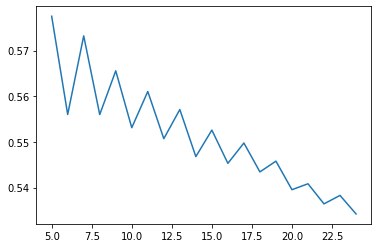

In [137]:
plt.plot(range(5, 25), knn_score)

In [146]:
pca39_score = []
knn = KNeighborsClassifier(n_neighbors=39)
for c in range(10, 30):
    pca = PCA(n_components=c)
    X_vec_pca = pca.fit_transform(X_vec)
    acc = cross_val_score(knn, X_vec_pca, y, cv =5).mean()
    print(acc)
    pca39_score.append(acc)

0.6704749999999999
0.6754
0.6784250000000001
0.6799
0.6801
0.68225
0.6787
0.6796249999999999
0.678125
0.67635
0.67545
0.675425
0.675925
0.674425
0.6713250000000001
0.670275
0.668825
0.6675
0.667975
0.665175


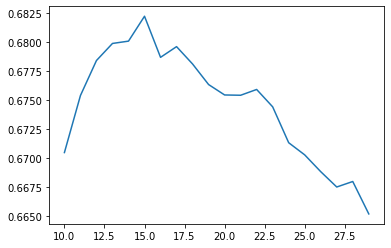

In [147]:
plt.plot(range(10, 30), pca39_score)

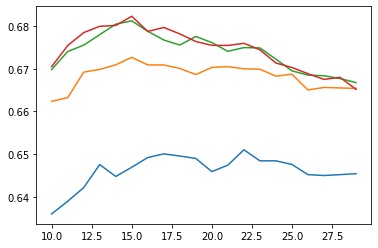

In [148]:
plt.plot(range(10, 30), pca_score)
plt.plot(range(10, 30), pca15_score)
plt.plot(range(10, 30), pca33_score)
plt.plot(range(10, 30), pca39_score)

In [149]:
%%time
pca = PCA(n_components=15)
X_vec_pca = pca.fit_transform(X_vec)

sv = svm.LinearSVC(C=1, multi_class = 'crammer_singer')
print(cross_val_score(sv, X_vec, y, cv = 5))
print(cross_val_score(sv, X_vec_pca, y, cv = 5))

[0.693    0.698125 0.69825  0.695375 0.70525 ]
[0.634625 0.638375 0.641    0.64475  0.644625]
Wall time: 27min 23s


In [150]:
%%time
scale_svm = make_pipeline(StandardScaler(),svm.LinearSVC(random_state=0, tol=1e-5, multi_class = 'crammer_singer'))
scale_svm_score = cross_val_score(scale_svm, X_vec, y, cv = 5)
print(scale_svm_score.mean())

0.6986
Wall time: 41min 27s


In [472]:
n_estimators=24
clf = OneVsRestClassifier(BaggingClassifier(svm.SVC(kernel='rbf', probability=True, gamma = 0.001,
                                               C=100, class_weight='balanced', max_iter=2000),
                                           n_jobs=-1, max_samples=1.0 / n_estimators, n_estimators=n_estimators))

In [ ]:
%%time
sv_score = []
C = [0.001, 0.01, 0.1, 1, 10, 100]
for c in C:
    scale_svm = make_pipeline(StandardScaler(),svm.LinearSVC(C = c, random_state=0, tol=1e-5, multi_class = 'crammer_singer'))
    scale_svm_score = cross_val_score(scale_svm, X_vec, y, cv = 4)
    sv_score.append(scale_svm_score)
plt.plot(C, sv_score)
plt.xscale('log')

In [319]:
scale_svm_score

array([0.6955, 0.6947, 0.7   , 0.7017])

In [406]:
%%time
C = [0.001, 0.01, 0.1, 1,  10]
#log_score = []
log_score_train= []
log_score_test= []
for c in C:
    log_reg = LogisticRegression(C = c, multi_class='multinomial')
    #acc = cross_val_score(log_reg, X_vec, y, cv = 5).mean()
    #print(acc)
    #log_score.append(acc)
    log_reg.fit(X_vec_train, y_train)
    log_score_train.append(log_reg.score(X_vec_train, y_train))
    log_score_test.append(log_reg.score(X_vec_test, y_test))

Wall time: 14.7 s


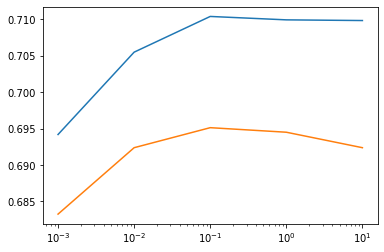

In [407]:
plt.plot(C, log_score_train)
plt.plot(C, log_score_test)
plt.xscale('log')

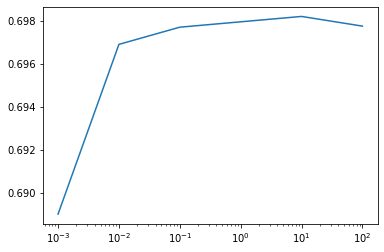

In [152]:
plt.plot(C, log_score)
plt.xscale('log')

In [155]:
%%time
C1 = range(20, 50)
#reg_score = []
for c in C1:
    log_reg = LogisticRegression(C = c, multi_class='multinomial')
    acc = cross_val_score(log_reg, X_vec, y, cv = 5).mean()
    print(acc)
    reg_score.append(acc)

0.697875
0.6975
0.698025
0.6981249999999999
0.6977
0.6978500000000001
0.69705
0.6975499999999999
0.6976500000000001
0.69795
0.69775
0.698025
0.697625
0.697575
0.6981250000000001
0.698025
0.69775
0.6984
0.6980250000000001
0.698275
0.6977249999999999
0.6984250000000001
0.6977249999999999
0.698075
0.69735
0.6975
0.698175
0.6978250000000001
0.6976000000000001
0.697975
Wall time: 14min 47s


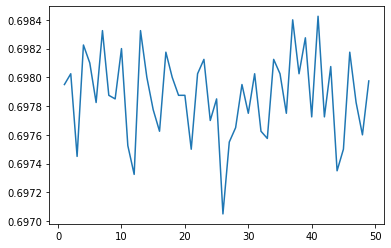

In [157]:
plt.plot(range(1, 50), reg_score)

In [493]:
log_reg = LogisticRegression(multi_class='multinomial')
log_reg.fit(X_vec_train, y_train)
print(evaluation.evaluate(log_reg.predict(X_vec_test), y_test))

Accuracy = 69.45%
   Precision  Recall  F_score
1     0.6804  0.6953   0.6877
2     0.7103  0.7272   0.7187
3     0.6267  0.3534   0.4519

Confusion matrix:
      1     2    3
1  2448  1047   26
2  1055  2967   58
3    95   163  141

None


In [473]:
%%time
vec_estimators = [
    ('knn', make_pipeline(PCA(n_components=15), KNeighborsClassifier(n_neighbors=39))),
    ('svm', make_pipeline(StandardScaler(),clf)),
    ('log_reg', LogisticRegression(multi_class='multinomial'))
]

vec_stacking = StackingClassifier(estimators = vec_estimators, final_estimator = LogisticRegression(multi_class='multinomial'))
vec_stacking.fit(X_vec_train, y_train)
#vec_stacking.score(X_vec_test, y_test)
vec_stack_predicted_test = stacking.predict(X_vec_test)
accuracy_score(y_test, vec_stack_predicted_test)
#vec_stack_predicted = stacking.predict(test_vec)
#vec_stack_predicted

KeyboardInterrupt: 

In [161]:
%%time
name1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/test_name_doc2vec50.csv", 
                   index_col = False, header = None)
steps1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/test_steps_doc2vec50.csv", 
                   index_col = False, header = None)
ingr1 = pd.read_csv(r"data/recipe_text_features_doc2vec50/test_ingr_doc2vec50.csv", 
                   index_col = False, header = None)

name2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/test_name_doc2vec100.csv", 
                   index_col = False, header = None)
steps2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/test_steps_doc2vec100.csv", 
                   index_col = False, header = None)
ingr2 = pd.read_csv(r"data/recipe_text_features_doc2vec100/test_ingr_doc2vec100.csv", 
                   index_col = False, header = None)

name = np.hstack((name1, name2))
steps = np.hstack((steps1, steps2))
ingr = np.hstack((ingr1, ingr2))

del name1, steps1,ingr1,name2,steps2,ingr2

test_vec = np.hstack((name, steps, ingr))

del name, steps, ingr

Wall time: 2.11 s


In [164]:
X_vec.shape

(40000, 450)

In [162]:
%%time
vec_stacking_all = StackingClassifier(estimators=vec_estimators,final_estimator=LogisticRegression(multi_class='multinomial'))
vec_stacking_all.fit(X_vec, y)
vec_stack_all_predicted = vec_stacking_all.predict(test_vec)
vec_stack_all_predicted

ValueError: X has 450 features, but DecisionTreeClassifier is expecting 100 features as input.

In [165]:
vec_stack_all_predicted = vec_stacking_all.predict(test_vec)
vec_stack_all_predicted

array([2., 1., 1., ..., 1., 1., 2.])

In [456]:
vec_stack_all_predicted_train = vec_stacking_all.predict(X_vec)
vec_stack_all_predicted_test = vec_stacking_all.predict(test_vec)

stacking

In [ ]:
metaclassifier = LogisticRegression(C = 0.01, multi_class = 'multinomial')
yhats = [stacking.predict_proba(X_f_vt_mi_mav),vec_stacking.predict_proba(X_vec)]

yhats = np.concatenate(yhats, axis=1)
#yhats = np.column_stack(yhats)

assert yhats.shape[0] == X_f_vt_mi_mav.shape[0]

metaclassifier.fit(yhats, y)

yhats = [stacking.predict_proba(test_f_vt_mi_mav),vec_stacking.predict_proba(test_vec)]

yhats = np.concatenate(yhats, axis=1)
#yhats = np.column_stack(yhats)
assert yhats.shape[0] == test_f_vt_mi_mav.shape[0]
yhat = metaclassifier.predict(yhats)

#print(accuracy_score(y_test, yhat))

output

In [ ]:
predicted = pd.DataFrame({'id':testingSet.index+1, 'duration_label':stack_predicted})
predicted.to_csv('predicted.csv', index = False)

Below are some legacy code from past attempts

In [18]:
D = pd.read_csv('data/train_steps_doc2vec50.csv', header = None, index_col = False)

In [19]:
Dt = pd.read_csv('data/test_steps_doc2vec50.csv', header = None, index_col = False)

In [20]:
D1 = pd.read_csv('data/train_steps_doc2vec100.csv', header = None, index_col = False)

In [21]:
D1t = pd.read_csv('data/test_steps_doc2vec100.csv', header = None, index_col = False)

In [22]:
Dt.shape

(10000, 50)

In [23]:
D1.shape

(40000, 100)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [25]:
T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.2, random_state=88)

In [26]:
D_train, D_test, y_train, y_test = train_test_split(D, y, test_size=0.2, random_state=88)

In [27]:
D1_train, D1_test, y_train, y_test = train_test_split(D1, y, test_size=0.2, random_state=88)

In [32]:
vt = VarianceThreshold(0.001)
X_vt_train = vt.fit_transform(X_train, y_train)
X_vt_test = vt.transform(X_test)

In [33]:
X_vt = vt.fit_transform(X, y)

In [34]:
test_vt = vt.transform(test) 

In [35]:
print(X_vt.shape)

(40000, 2676)


In [36]:
C= 3.7
k = 600

In [37]:
models = [GaussianNB(),
          MultinomialNB(),
          DecisionTreeClassifier(max_depth=1),
          DecisionTreeClassifier(max_depth=None),
          svm.LinearSVC(C=C),
          LogisticRegression()]
titles = ['GNB',
          'MNB',
          'one-r',
          'Decision Tree',
          'LinearSVC',
          'Logistic Regression']

In [38]:
x2 = SelectFdr(chi2, alpha = 0.01)
x2.fit(X_train,y_train)
X_train_x2 = x2.transform(X_train)
X_test_x2 = x2.transform(X_test)

In [39]:
print(X_train_x2.shape)

(32000, 757)


In [40]:
f = SelectFdr(f_classif, alpha = 0.01)
f.fit(X_train,y_train)
X_train_f = f.transform(X_train)
X_test_f = f.transform(X_test)

In [41]:
print(X_train_f.shape)

(32000, 705)


In [42]:
mi = SelectKBest(mutual_info_classif, k = k)
mi.fit(X_train,y_train)
X_train_mi = mi.transform(X_train)
X_test_mi = mi.transform(X_test)

In [31]:
print(X_train_mi.shape)

(32000, 600)


In [66]:
%%time
Xs = [(X_train, X_test), (X_train_x2, X_test_x2), (X_train_f, X_test_f), (X_train_mi, X_test_mi)]

X_names = ['complete', 'x2', 'f', 'mi']

for title, model in zip(titles, models):
    print('\n',title, '(with k=',k,'features):')
    for X_name, Xt in zip(X_names, Xs):
        X_train_t, X_test_t = Xt
        model.fit(X_train_t.todense(), y_train)
        acc = model.score(X_test_t.todense(), y_test)
        print(X_name, '\t acc',  acc)


 GNB (with k= 586 features):
complete 	 acc 0.511
x2 	 acc 0.56275
f 	 acc 0.6
mi 	 acc 0.616875

 MNB (with k= 586 features):
complete 	 acc 0.714875
x2 	 acc 0.71125
f 	 acc 0.709875
mi 	 acc 0.70825

 one-r (with k= 586 features):
complete 	 acc 0.65475
x2 	 acc 0.65475
f 	 acc 0.65475
mi 	 acc 0.65475

 Decision Tree (with k= 586 features):
complete 	 acc 0.72625
x2 	 acc 0.726375
f 	 acc 0.72425
mi 	 acc 0.72675

 LinearSVC (with k= 586 features):
complete 	 acc 0.788375
x2 	 acc 0.78975
f 	 acc 0.789875
mi 	 acc 0.788

 Logistic Regression (with k= 586 features):
complete 	 acc 0.7925
x2 	 acc 0.788125
f 	 acc 0.78975
mi 	 acc 0.793875
Wall time: 3min 22s


In [ ]:
models = [LogisticRegression(),
          Ridge(0.01),
          Lasso(0.01)]
titles = ['Logistic Regression',
          '',
          '']

In [126]:
%%time
lst = []
model = LogisticRegression()
for k in range(500, 801, 25):
    mi = SelectKBest(mutual_info_classif, k = k)
    mi.fit(X_vt,y)
    X_vt_mi = mi.transform(X_vt)
    acc = cross_val_score(model, X_vt_mi, y, cv = 4)
    print(k, acc)
    lst.append(acc.mean())

500 [0.7924 0.7881 0.7957 0.7991]
525 [0.7911 0.7863 0.7962 0.7993]
550 [0.7911 0.7871 0.7949 0.798 ]
575 [0.7913 0.7869 0.7945 0.796 ]
600 [0.7925 0.7914 0.7982 0.8012]
625 [0.792  0.7916 0.7977 0.801 ]
650 [0.7923 0.7906 0.7988 0.8003]
675 [0.7924 0.7917 0.7995 0.7997]
700 [0.7928 0.7944 0.7998 0.7984]
725 [0.7931 0.7942 0.7997 0.7992]
750 [0.7932 0.7948 0.8001 0.8002]
775 [0.7912 0.7931 0.7994 0.7996]
800 [0.7925 0.7942 0.7998 0.8022]
Wall time: 2min 48s


In [44]:
plt.plot(range(500, 801, 25), lst)

NameError: name 'lst' is not defined

In [23]:
MNB = MultinomialNB()
MNB.fit(X, y)
MNB_predicted = MNB.predict(test)
MNB.score(X,y)

0.751825

In [17]:
X_vt.shape

(40000, 888)

In [26]:
mi = SelectKBest(mutual_info_classif, k = 874)
X_vt_mi = mi.fit_transform(X_vt, y)
test_vt_mi = mi.transform(test_vt)

In [36]:
%%time
rc = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv = 5)
rc.fit(X_vt_mi, y)
rc_mi = rc.score(X_vt_mi,y)
rc_mi

NameError: name 'X_vt_mi' is not defined

In [226]:
df = 50
vectorizer = CountVectorizer(stop_words = 'english', min_df = df)
X_new = vectorizer.fit_transform(data['steps'])
test_new = vectorizer.transform(testingSet['steps'])
X_new = sparse.csr_matrix(X_new)
test_new = sparse.csr_matrix(test_new)
T_new = tfidf.fit_transform(X_new)
print(T_new.shape)
print(test_new.shape)

(40000, 2017)
(10000, 2017)


In [191]:
%%time
xdf1 = []
tdf1 = []
for df in range(150,250):
    print(df)
    logreg = LogisticRegression()
    vectorizer = CountVectorizer(stop_words = 'english', min_df = df)
    X_new = vectorizer.fit_transform(data['steps'])
    X_new = sparse.csr_matrix(X_new)
    T_new = tfidf.fit_transform(X_new)
    
    print(X_new.shape)
    print(T_new.shape)
    
    Xnew_train, Xnew_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=88)
    Tnew_train, Tnew_test, y_train, y_test = train_test_split(T_new, y, test_size=0.2, random_state=88)
    
    logreg.fit(Xnew_train, y_train)
    acc =logreg.score(Xnew_test, y_test)
    print(acc)
    xdf1.append(acc)
    
    
    logreg.fit(Tnew_train, y_train)
    acc =logreg.score(Tnew_test, y_test)
    print(acc)
    tdf1.append(acc)


150
(40000, 1176)
(40000, 1176)
0.785125
0.78825
151
(40000, 1174)
(40000, 1174)
0.787
0.787875
152
(40000, 1169)
(40000, 1169)
0.785625
0.788
153
(40000, 1167)
(40000, 1167)
0.786375
0.78825
154
(40000, 1163)
(40000, 1163)
0.788375
0.78775
155
(40000, 1159)
(40000, 1159)
0.787125
0.788125
156
(40000, 1155)
(40000, 1155)
0.787
0.787625
157
(40000, 1153)
(40000, 1153)
0.7875
0.787875
158
(40000, 1149)
(40000, 1149)
0.78675
0.787875
159
(40000, 1146)
(40000, 1146)
0.7885
0.788125
160
(40000, 1139)
(40000, 1139)
0.7885
0.7885
161
(40000, 1134)
(40000, 1134)
0.787
0.7885
162
(40000, 1127)
(40000, 1127)
0.788125
0.78875
163
(40000, 1124)
(40000, 1124)
0.787875
0.788375
164
(40000, 1119)
(40000, 1119)
0.788625
0.788375
165
(40000, 1114)
(40000, 1114)
0.788625
0.7885
166
(40000, 1109)
(40000, 1109)
0.788125
0.788375
167
(40000, 1108)
(40000, 1108)
0.789125
0.78875
168
(40000, 1103)
(40000, 1103)
0.787875
0.7885
169
(40000, 1096)
(40000, 1096)
0.7875
0.789125
170
(40000, 1094)
(40000, 1094)
0.

In [189]:
print(X.shape)
print(X_new.shape)

(40000, 17967)
(40000, 667)


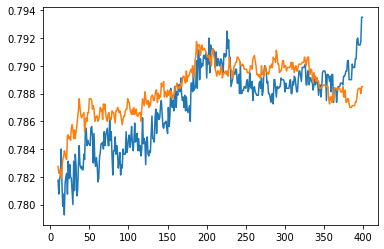

In [190]:
plt.plot(range(10,400), xdf)
plt.plot(range(10,400), tdf)

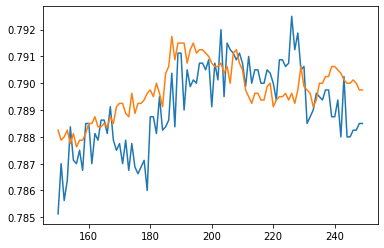

In [192]:
plt.plot(range(150,250), xdf1)
plt.plot(range(150,250), tdf1)

In [58]:
%%time
Xtune_df_train = []
Xtune_df_test = []
Ttune_df_train = []
Ttune_df_test = []
dfs = [20, 30, 40, 50, 60]
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 260]
for df in dfs:
    Xtune_a_train = []
    Xtune_a_test = []
    Ttune_a_train = []
    Ttune_a_test = []
    for a in alphas:
        print(df)
        logreg = LogisticRegression()
        vectorizer = CountVectorizer(stop_words = 'english', min_df = df)
        X_new = vectorizer.fit_transform(data['steps'])
        X_new = sparse.csr_matrix(X_new)
        T_new = tfidf.fit_transform(X_new)

        print(X_new.shape)
        print(T_new.shape)

        Xnew_train, Xnew_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=88)
        Tnew_train, Tnew_test, y_train, y_test = train_test_split(T_new, y, test_size=0.2, random_state=88)
        
        rc = RidgeClassifier(alpha = a)

        #training and testing
        rc.fit(Xnew_train, y_train)
        acc = cross_val_score(rc,Xnew_train,y_train, cv = 5)
        print("Ridge Regerssion on countvectorser with min_df select: ", acc)
        Xtune_a_train.append(acc.mean())
        acc = rc.score(Xnew_test, y_test)
        Xtune_a_test.append(acc)
        
        #training and testing
        rc.fit(Tnew_train, y_train)
        acc = cross_val_score(rc,Tnew_train,y_train, cv = 5)
        print("Ridge Regerssion on tfidfvectorser with min_df select: ", acc)
        Ttune_a_train.append(acc.mean())
        acc = rc.score(Tnew_test, y_test)
        Ttune_a_test.append(acc)
        
    Xtune_df_train.append(Xtune_a_train)
    Xtune_df_test.append(Xtune_a_test)
    Ttune_df_train.append(Ttune_a_train)
    Ttune_df_test.append(Ttune_a_test)

20
(40000, 3024)
(40000, 3024)
Ridge Regerssion on countvectorser with min_df select:  [0.77765625 0.7675     0.77671875 0.77046875 0.7728125 ]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.77734375 0.76625    0.7834375  0.77515625 0.77421875]
20
(40000, 3024)
(40000, 3024)
Ridge Regerssion on countvectorser with min_df select:  [0.7775     0.76734375 0.7765625  0.77046875 0.77265625]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.77734375 0.76578125 0.7834375  0.7753125  0.77390625]
20
(40000, 3024)
(40000, 3024)
Ridge Regerssion on countvectorser with min_df select:  [0.77765625 0.7671875  0.7765625  0.7703125  0.7728125 ]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.77734375 0.765625   0.78328125 0.775625   0.77421875]
20
(40000, 3024)
(40000, 3024)
Ridge Regerssion on countvectorser with min_df select:  [0.7775     0.7671875  0.77640625 0.77109375 0.7728125 ]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.7771875  0.76625    0.7839

(40000, 2017)
(40000, 2017)
Ridge Regerssion on countvectorser with min_df select:  [0.788125   0.77109375 0.784375   0.78109375 0.78015625]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.7934375  0.77953125 0.79328125 0.78875    0.7859375 ]
50
(40000, 2017)
(40000, 2017)
Ridge Regerssion on countvectorser with min_df select:  [0.789375   0.7728125  0.78703125 0.7821875  0.78265625]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.79203125 0.7821875  0.79515625 0.78859375 0.7803125 ]
50
(40000, 2017)
(40000, 2017)
Ridge Regerssion on countvectorser with min_df select:  [0.79328125 0.78       0.7915625  0.78984375 0.78609375]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.7578125  0.7525     0.76484375 0.75671875 0.75109375]
50
(40000, 2017)
(40000, 2017)
Ridge Regerssion on countvectorser with min_df select:  [0.79078125 0.78265625 0.795      0.78828125 0.7859375 ]
Ridge Regerssion on tfidfvectorser with min_df select:  [0.73375    0.7221875  0.7323437

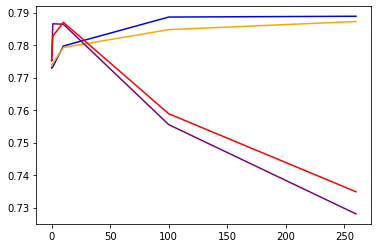

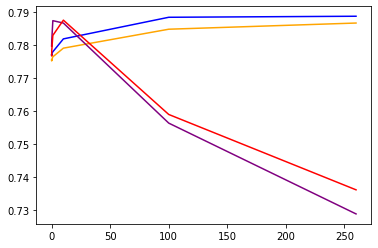

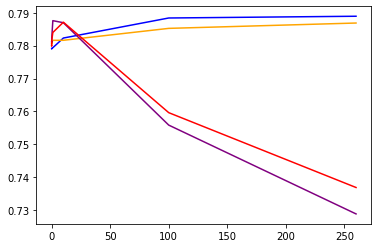

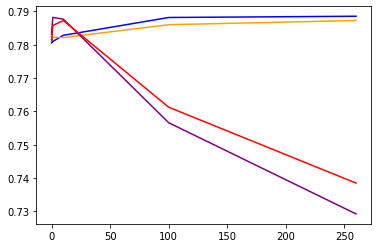

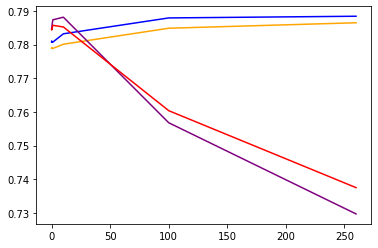

In [149]:
for i in range(len(Xtune_df_train)):
    plt.figure(i)
    plt.plot(alphas, Xtune_df_train[i], c = 'blue', label = "df: " + str(dfs[i]))
    plt.plot(alphas, Xtune_df_test[i], c = 'orange', label = "df: " + str(dfs[i]))
    plt.plot(alphas, Ttune_df_train[i], c = 'purple' , label = "df: " + str(dfs[i]))
    plt.plot(alphas, Ttune_df_test[i], c= 'red', label = "df: " + str(dfs[i]))
    #plt.xscale("log")

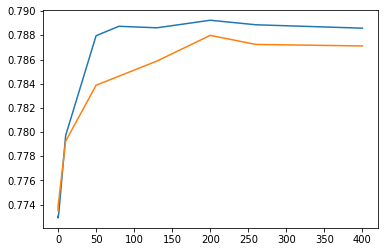

In [46]:
plt.plot([1e-5, 1e-3, 1, 10, 50, 80, 130, 200, 260, 400], Xtune_df_train[0])
plt.plot([1e-5, 1e-3, 1, 10, 50, 80, 130, 200, 260, 400], Xtune_df_test[0])

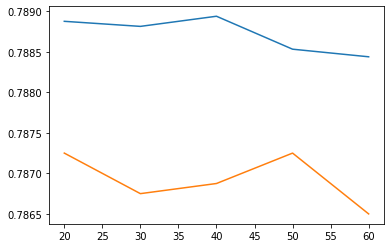

In [84]:
plt.plot(dfs, [s[-1] for s in Xtune_df_train])
plt.plot(dfs, [s[-1] for s in Xtune_df_test])

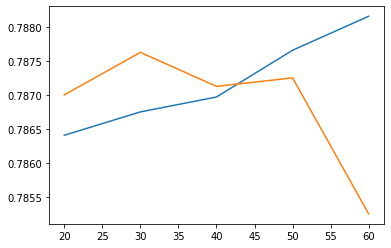

In [88]:
plt.plot(dfs, [s[6] for s in Ttune_df_train])
plt.plot(dfs, [s[6] for s in Ttune_df_test])

In [ ]:
plt.plot(dfs, [s[-1] for s in Ttune_df_train])
plt.plot(dfs, [s[-1] for s in Ttune_df_test])

In [159]:
xvt = []
tvt = []
for a in [0.00001, 0.0001, 0.001, 0.01]:
    logreg = LogisticRegression()
    vt = VarianceThreshold(a)
    X_train_vt = vt.fit_transform(X_train, y_train)
    X_test_vt = vt.transform(X_test)
    print(X_train_vt.shape)
    
    
    logreg.fit(X_train_vt, y_train)
    acc =logreg.score(X_test_vt, y_test)
    print(acc)
    xvt.append(acc)
    
    T_train_vt = vt.fit_transform(T_train, y_train)
    T_test_vt = vt.transform(T_test)
    print(T_train_vt.shape)
    
    logreg.fit(T_train_vt, y_train)
    acc =logreg.score(T_test_vt, y_test)
    print(acc)
    tvt.append(acc)
    

(32000, 897)
0.7925
(32000, 5209)
0.778625
(32000, 897)
0.7925
(32000, 1562)
0.77825
(32000, 897)
0.7925
(32000, 210)
0.748625
(32000, 897)
0.7925


ValueError: No feature in X meets the variance threshold 0.01000

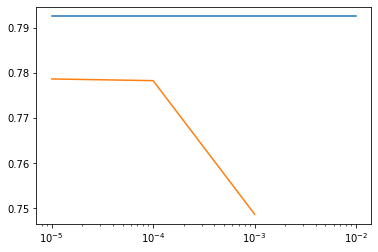

In [162]:
plt.plot([0.00001, 0.0001, 0.001, 0.01], xvt)
plt.plot([0.00001, 0.0001, 0.001], tvt)
plt.xscale("log")

In [ ]:
#feature selection with f_classif
X_f = f.fit_transform(X_train, y_train)
X_f_test = f.transform(X_test)
print(X_f.shape)

T_f = f.fit_transform(T_train, y_train)
T_f_test = f.transform(T_test)
print(T_f.shape)

D_f = f.fit_transform(D_train, y_train)
D_f_test = f.transform(D_test)
print(D_f.shape)

D1_f = f.fit_transform(D1_train, y_train)
D1_f_test = f.transform(D1_test)
print(D_f.shape)


In [218]:
#feature selection 
vectorizer = CountVectorizer(stop_words = 'english', min_df = 50)
X_new = vectorizer.fit_transform(data['steps'])
X_new = sparse.csr_matrix(X_new)
test_new = vectorizer.transform(testingSet['steps'])
test_new = sparse.csr_matrix(test_new)
T_new = tfidf.fit_transform(X_new)
test_new_t= tfidf.transform(test_new)
print(X_new.shape)
print(T_new.shape)

X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=88)
T_new_train, T_new_test, y_train, y_test = train_test_split(T_new, y, test_size=0.2, random_state=88)

pca = PCA(n_components=20)
D_train_pca = pca.fit_transform(D_train)
D_test_pca = pca.transform(D_test)
print(D_train_pca.shape)

D1_train_pca = pca.fit_transform(D1_train, y_train)
D1_test_pca = pca.transform(D1_test)
print(D1_train_pca.shape)

(40000, 2017)
(40000, 2017)


NameError: name 'D_train' is not defined

In [42]:
%%time
#svm
sv = svm.LinearSVC(C=1, multi_class = 'crammer_singer')

#training and testing
sv.fit(X_f, y_train)
print("Support Vector Machine on countvectorser with f_classif feature select: ", sv.score(X_f_test, y_test))
sv.fit(T_f, y_train)
print("Support Vector Machine on tfidfvectorser with f_classif feature select: ", sv.score(T_f_test, y_test))
sv.fit(D_f, y_train)
print("Support Vector Machine on doc2vec50 with f_classif feature select: ", sv.score(D_f_test, y_test))
sv.fit(D1_f, y_train)
print("Support Vector Machine on doc2vec100 with f_classif feature select: ", sv.score(D1_f_test, y_test))

Support Vector Machine on countvectorser with f_classif feature select:  0.7905
Support Vector Machine on tfidfvectorser with f_classif feature select:  0.781625
Support Vector Machine on doc2vec50 with f_classif feature select:  0.644875
Support Vector Machine on doc2vec100 with f_classif feature select:  0.654625
Wall time: 2min


In [161]:
%%time
#ridge regerssion
logreg = LogisticRegression()

#training and testing
#logreg.fit(X_f, y_train)
#print("Logistic Regerssion on countvectorser with f_classif feature select: ", logreg.score(X_f_test, y_test))
#logreg.fit(T_f, y_train)
#print("Logistic Regerssion on tfidfvectorser with f_classif feature select: ", logreg.score(T_f_test, y_test))
logreg.fit(D_train, y_train)
print("Logistic Regerssion on doc2vec50 with f_classif feature select: ", logreg.score(D_test, y_test))
logreg.fit(D1_train, y_train)
print("Logistic Regerssion on doc2vec100 with f_classif feature select: ", logreg.score(D1_test, y_test))

Logistic Regerssion on doc2vec50 with f_classif feature select:  0.645875
Logistic Regerssion on doc2vec100 with f_classif feature select:  0.659375
Wall time: 2.75 s


In [111]:
%%time
#ridge regerssion
rc_train = []
rc_test = []
mses = []
for a in range(1, 500, 1):
    rc = RidgeClassifier(alpha = a)

    #training and testing
    rc.fit(X_f, y_train)
    acc = cross_val_score(rc,X_f,y_train, cv = 5)
    print("Ridge Regerssion on countvectorser with f_classif feature select: ", acc)
    rc_train.append(acc.mean())
    acc = rc.score(X_f_test, y_test)
    rc_test.append(acc)
    mse = mean_squared_error(y_test, rc.predict(X_f_test))
    mses.append(mse)

Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.779375   0.79515625 0.78484375 0.7834375 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.779375   0.7953125  0.78484375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79       0.7796875  0.79546875 0.78484375 0.7834375 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79       0.77921875 0.795625   0.7846875  0.7834375 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79       0.77921875 0.79578125 0.785      0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.77921875 0.795625   0.784375   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.77921875 0.7953125  0.784375   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.779375   0.79515625 0.7846875  0.783125  ]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.78953125 0.7815625  0.7959375  0.78359375 0.7825    ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78953125 0.78171875 0.7959375  0.78421875 0.7825    ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.781875   0.7959375  0.78421875 0.7825    ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78953125 0.781875   0.79578125 0.78390625 0.78234375]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.781875   0.79578125 0.78390625 0.7821875 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.79578125 0.7840625  0.7825    ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.781875   0.79546875 0.7840625  0.7825    ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.795625   0.784375   0.7828125 ]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.78203125 0.795625   0.785      0.7828125 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.78203125 0.79546875 0.785      0.78265625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.78203125 0.79546875 0.785      0.7828125 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79015625 0.7821875  0.79546875 0.78484375 0.7828125 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79015625 0.7821875  0.7953125  0.785      0.78265625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79015625 0.7821875  0.79546875 0.785      0.78265625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.7821875  0.79546875 0.785      0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78984375 0.78171875 0.79546875 0.785      0.78296875]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.78296875 0.79578125 0.7859375  0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.78296875 0.7959375  0.7859375  0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.783125   0.7959375  0.7859375  0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.783125   0.79578125 0.78609375 0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78953125 0.783125   0.79578125 0.78609375 0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7896875  0.78296875 0.79578125 0.78609375 0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7896875  0.7828125  0.7959375  0.78609375 0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78953125 0.78296875 0.7959375  0.7859375  0.783125  ]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.781875   0.79515625 0.78609375 0.78390625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.78171875 0.79515625 0.78625    0.7840625 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.79515625 0.78625    0.78390625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.7953125  0.78640625 0.78390625]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.7953125  0.78640625 0.7840625 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.7953125  0.78640625 0.7840625 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.79515625 0.78640625 0.7840625 ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78921875 0.78171875 0.79515625 0.7865625  0.78421875]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.7903125  0.7809375  0.79390625 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7903125  0.7809375  0.79390625 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7903125  0.7809375  0.79390625 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79046875 0.78078125 0.7940625  0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79046875 0.7809375  0.79390625 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7903125  0.7809375  0.79390625 0.78796875 0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7903125  0.7809375  0.7940625  0.78796875 0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.79015625 0.7809375  0.7940625  0.788125   0.783125  ]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.7890625  0.781875   0.79234375 0.78828125 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.78171875 0.79234375 0.78828125 0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7890625  0.78171875 0.79234375 0.78828125 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.7890625  0.781875   0.79234375 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.789375   0.781875   0.79234375 0.78796875 0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78890625 0.78203125 0.79234375 0.788125   0.783125  ]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78890625 0.7821875  0.79234375 0.7878125  0.78296875]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78890625 0.7821875  0.7925     0.78765625 0.783125  ]
Ridge Re

Ridge Regerssion on countvectorser with f_classif feature select:  [0.78875    0.781875   0.7921875  0.78765625 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78875    0.781875   0.79203125 0.78734375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78875    0.78203125 0.79203125 0.78734375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78875    0.78203125 0.79203125 0.78734375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78859375 0.78203125 0.79203125 0.7875     0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78859375 0.78203125 0.79203125 0.78734375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78859375 0.78203125 0.79203125 0.78734375 0.78328125]
Ridge Regerssion on countvectorser with f_classif feature select:  [0.78859375 0.78203125 0.79203125 0.78734375 0.78328125]
Ridge Re

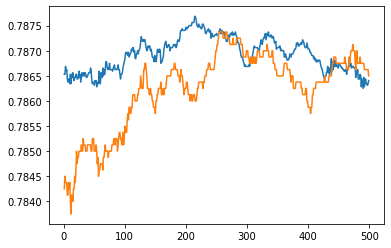

In [112]:
plt.plot(range(1, 500, 1), rc_train)
plt.plot(range(1, 500, 1), rc_test)

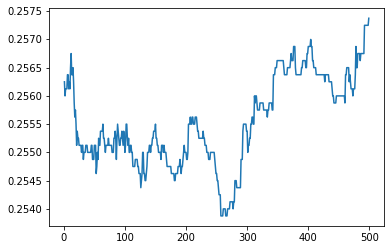

In [113]:
plt.plot(range(1, 500, 1), mses)

In [162]:
%%time
#ridge regerssion
rc = RidgeClassifierCV(alphas=[1,5, 10,15, 20, 25,30, 35,40, 45,50, 55,60, 65,70, 75,80], cv = 5)

#training and testing
#rc.fit(X_f, y_train)
#print("Ridge Regerssion on countvectorser with f_classif feature select: ", rc.score(X_f_test, y_test))
#rc.fit(T_f, y_train)
#print("Ridge Regerssion on tfidfvectorser with f_classif feature select: ", rc.score(T_f_test, y_test))
rc.fit(D_train, y_train)
print("Ridge Regerssion on doc2vec50 with f_classif feature select: ", rc.score(D_test, y_test))
rc.fit(D1_train, y_train)
print("Ridge Regerssion on doc2vec100 with f_classif feature select: ", rc.score(D1_test, y_test))

Ridge Regerssion on doc2vec50 with f_classif feature select:  0.6425
Ridge Regerssion on doc2vec100 with f_classif feature select:  0.651625
Wall time: 12.9 s


In [84]:
%%time
#ridge regerssion
rc = RidgeClassifierCV(alphas=[1e-2, 1e-1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90], cv = 5)

#training and testing
rc.fit(X_train, y_train)
print("Ridge Regerssion on countvectorser with f_classif feature select: ", rc.score(X_test, y_test))
rc.fit(T_train, y_train)
print("Ridge Regerssion on tfidfvectorser with f_classif feature select: ", rc.score(T_test, y_test))
rc.fit(D_train, y_train)
print("Ridge Regerssion on doc2vec50 with f_classif feature select: ", rc.score(D_test, y_test))
rc.fit(D1_train, y_train)
print("Ridge Regerssion on doc2vec100 with f_classif feature select: ", rc.score(D1_test, y_test))

Ridge Regerssion on countvectorser with f_classif feature select:  0.787625
Ridge Regerssion on tfidfvectorser with f_classif feature select:  0.77875
Ridge Regerssion on doc2vec50 with f_classif feature select:  0.6425
Ridge Regerssion on doc2vec100 with f_classif feature select:  0.651
Wall time: 59.3 s


In [41]:
%%time
#random forest
rf = RandomForestClassifier(random_state=0)

#training and testing
rf.fit(X_f, y_train)
print("Random Forest on countvectorser with f_classif feature select: ", rf.score(X_f_test, y_test))
rf.fit(T_f, y_train)
print("Random Forest on tfidfvectorser with f_classif feature select: ", rf.score(T_f_test, y_test))
rf.fit(D_f, y_train)
print("Random Forest on doc2vec50 with f_classif feature select: ", rf.score(D_f_test, y_test))
rf.fit(D1_f, y_train)
print("Random Forest on doc2vec100 with f_classif feature select: ", rf.score(D1_f_test, y_test))

Random Forest on countvectorser with f_classif feature select:  0.797125
Random Forest on tfidfvectorser with f_classif feature select:  0.794375
Random Forest on doc2vec50 with f_classif feature select:  0.670125
Random Forest on doc2vec100 with f_classif feature select:  0.666
Wall time: 2min 54s


In [55]:
len(range(31,100,2))

35

In [65]:
mat = MaxAbsScaler()
X_train_mav = mat.fit_transform(X_train)
X_test_mav = mat.transform(X_test)

In [69]:
%%time
#light gbm
newX_train = lgb.Dataset(X_train_mav, label = (y_train - 1))
newT_train = lgb.Dataset(T_train, label = (y_train - 1))
newD_train = lgb.Dataset(D_train, label = (y_train - 1))
newD1_train = lgb.Dataset(D1_train, label = (y_train - 1))

dartX = []
dartT = []
dartD = []
dartD1 = []

for l in range(50,100,1):
    print("num_leaves: ", l)
      
    lgbm_params = {'learning_rate': 0.05, 'boosting_type': 'dart', 'objective': 'multiclass', 'metric': 'multi_logloss',
                  'num_leaves': l,
                  'max_depth': 10,
                  'num_class': 3,
                  'verbosity': -1}

    
    #training and testing
    lgb_model = lgb.train(lgbm_params, newX_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(X_test_mav)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on countvectorser with f_classif feature select: ", acc)
    dartX.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newT_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(T_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on tfidfvectorser with f_classif feature select: ", acc)
    dartT.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newD_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(D_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on doc2vec50 with f_classif feature select: ", acc)
    dartD.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newD1_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(D1_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on doc5vec100 with f_classif feature select: ", acc)
    dartD1.append(acc)

num_leaves:  50
LightGBM on countvectorser with f_classif feature select:  0.7955
LightGBM on tfidfvectorser with f_classif feature select:  0.79325
LightGBM on doc2vec50 with f_classif feature select:  0.667625
LightGBM on doc5vec100 with f_classif feature select:  0.667
num_leaves:  51
LightGBM on countvectorser with f_classif feature select:  0.794375
LightGBM on tfidfvectorser with f_classif feature select:  0.793125
LightGBM on doc2vec50 with f_classif feature select:  0.665625
LightGBM on doc5vec100 with f_classif feature select:  0.662125
num_leaves:  52
LightGBM on countvectorser with f_classif feature select:  0.7965
LightGBM on tfidfvectorser with f_classif feature select:  0.792625
LightGBM on doc2vec50 with f_classif feature select:  0.66825
LightGBM on doc5vec100 with f_classif feature select:  0.663375
num_leaves:  53
LightGBM on countvectorser with f_classif feature select:  0.79475
LightGBM on tfidfvectorser with f_classif feature select:  0.79475
LightGBM on doc2vec50 

LightGBM on doc5vec100 with f_classif feature select:  0.66675
num_leaves:  80
LightGBM on countvectorser with f_classif feature select:  0.79675
LightGBM on tfidfvectorser with f_classif feature select:  0.795625
LightGBM on doc2vec50 with f_classif feature select:  0.668
LightGBM on doc5vec100 with f_classif feature select:  0.670125
num_leaves:  81
LightGBM on countvectorser with f_classif feature select:  0.796875
LightGBM on tfidfvectorser with f_classif feature select:  0.794875
LightGBM on doc2vec50 with f_classif feature select:  0.673375
LightGBM on doc5vec100 with f_classif feature select:  0.667
num_leaves:  82
LightGBM on countvectorser with f_classif feature select:  0.797625
LightGBM on tfidfvectorser with f_classif feature select:  0.7955
LightGBM on doc2vec50 with f_classif feature select:  0.670625
LightGBM on doc5vec100 with f_classif feature select:  0.6685
num_leaves:  83
LightGBM on countvectorser with f_classif feature select:  0.796125
LightGBM on tfidfvectorser 

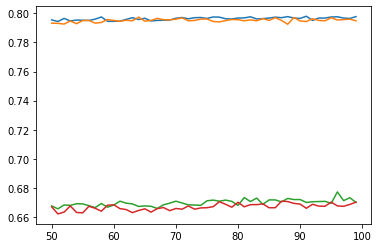

In [73]:
plt.plot(range(50,100,1), dartX)
plt.plot(range(50,100,1), dartT)
plt.plot(range(50,100,1), dartD)
plt.plot(range(50,100,1), dartD1)

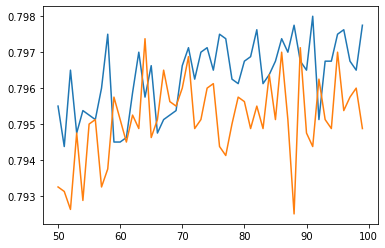

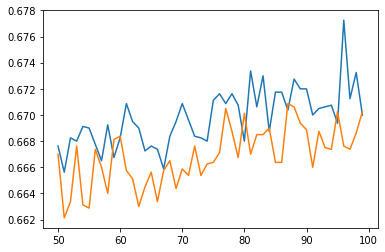

In [78]:
%%time
gbdtX = []
gbdtT = []
gbdtD = []
gbdtD1 = []

for l in range(50,100,1):
    print("num_leaves: ", l)
      
    lgbm_params = {'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
                  'num_leaves': l,
                  'max_depth': 10,
                  'num_class': 3,
                  'verbosity': -1}

    
    #training and testing
    lgb_model = lgb.train(lgbm_params, newX_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(X_test_mav)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on countvectorser with f_classif feature select: ", acc)
    gbdtX.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newT_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(T_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on tfidfvectorser with f_classif feature select: ", acc)
    gbdtT.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newD_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(D_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on doc2vec50 with f_classif feature select: ", acc)
    gbdtD.append(acc)

    #training and testing
    lgb_model = lgb.train(lgbm_params, newD1_train, 50)
    #prediction on test
    lgb_prediction = lgb_model.predict(D1_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on doc5vec100 with f_classif feature select: ", acc)
    gbdtD1.append(acc)

num_leaves:  50
LightGBM on countvectorser with f_classif feature select:  0.7995
LightGBM on tfidfvectorser with f_classif feature select:  0.797625
LightGBM on doc2vec50 with f_classif feature select:  0.676125
LightGBM on doc5vec100 with f_classif feature select:  0.66725
num_leaves:  51
LightGBM on countvectorser with f_classif feature select:  0.800625
LightGBM on tfidfvectorser with f_classif feature select:  0.799625
LightGBM on doc2vec50 with f_classif feature select:  0.675375
LightGBM on doc5vec100 with f_classif feature select:  0.67375
num_leaves:  52
LightGBM on countvectorser with f_classif feature select:  0.802625
LightGBM on tfidfvectorser with f_classif feature select:  0.798375
LightGBM on doc2vec50 with f_classif feature select:  0.6755
LightGBM on doc5vec100 with f_classif feature select:  0.66925
num_leaves:  53
LightGBM on countvectorser with f_classif feature select:  0.8
LightGBM on tfidfvectorser with f_classif feature select:  0.800375
LightGBM on doc2vec50 w

LightGBM on countvectorser with f_classif feature select:  0.802
LightGBM on tfidfvectorser with f_classif feature select:  0.799625
LightGBM on doc2vec50 with f_classif feature select:  0.678875
LightGBM on doc5vec100 with f_classif feature select:  0.674
num_leaves:  81
LightGBM on countvectorser with f_classif feature select:  0.80125
LightGBM on tfidfvectorser with f_classif feature select:  0.800125
LightGBM on doc2vec50 with f_classif feature select:  0.67825
LightGBM on doc5vec100 with f_classif feature select:  0.674875
num_leaves:  82
LightGBM on countvectorser with f_classif feature select:  0.802125
LightGBM on tfidfvectorser with f_classif feature select:  0.8005
LightGBM on doc2vec50 with f_classif feature select:  0.679
LightGBM on doc5vec100 with f_classif feature select:  0.672625
num_leaves:  83
LightGBM on countvectorser with f_classif feature select:  0.801875
LightGBM on tfidfvectorser with f_classif feature select:  0.798375
LightGBM on doc2vec50 with f_classif fea

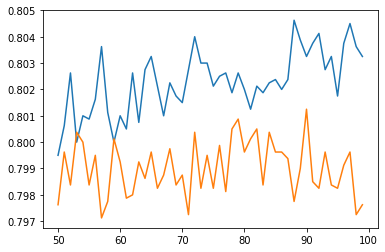

In [79]:
plt.plot(range(50,100,1), gbdtX)
plt.plot(range(50,100,1), gbdtT)

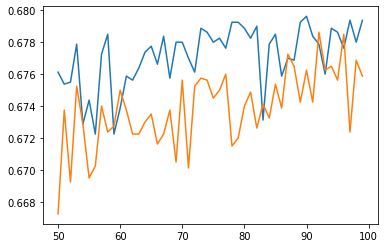

In [80]:
plt.plot(range(50,100,1), gbdtD)
plt.plot(range(50,100,1), gbdtD1)

In [105]:
mat = MaxAbsScaler()
X_new_train_mav = mat.fit_transform(X_new_train)
X_new_test_mav = mat.transform(X_new_test)

In [106]:
newX_train = lgb.Dataset(X_new_train_mav, label = (y_train - 1))
newT_train = lgb.Dataset(T_new_train, label = (y_train - 1))
newD_train = lgb.Dataset(D_train_pca, label = (y_train - 1))
newD1_train = lgb.Dataset(D1_train_pca, label = (y_train - 1))

In [150]:
%%time
gbdtX = []
gbdtT = []
#gbdtD = []
#gbdtD1 = []

for l in range(50,100,1):
    print("num_leaves: ", l)
      
    lgbm_params = {'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
                  'num_leaves': l,
                  'max_depth': 10,
                  'num_class': 3,
                  'verbosity': -1}

    lgbm_params1 = {'metric': 'multi_logloss',
                  'num_class': 3,}
    
    #training and testing
    lgb_model = lgb.LGBMClassifier(**lgbm_params)
    lgb_model.fit(X_new_train_mav, y_train-1)
    #prediction on test
    lgb_prediction = lgb_model.predict(X_new_test_mav)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on countvectorser with f_classif feature select: ", acc)
    gbdtX.append(acc)

    #training and testing
    lgb_model = lgb.LGBMClassifier(**lgbm_params)
    lgb_model.fit(T_new_train, y_train-1)
    #prediction on test
    lgb_prediction = lgb_model.predict(T_new_test)
    #model predict probability, convert into classes
    lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    lgbm_prediction = lgbm_prediction+1
    acc = accuracy_score(y_test, lgbm_prediction)
    print("LightGBM on tfidfvectorser with f_classif feature select: ", acc)
    gbdtT.append(acc)

    #training and testing
    #lgb_model = lgb.train(lgbm_params, newD_train, 50)
    #prediction on test
    #lgb_prediction = lgb_model.predict(D_test_pca)
    #model predict probability, convert into classes
    #lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    #lgbm_prediction = lgbm_prediction+1
    #acc = accuracy_score(y_test, lgbm_prediction)
    #print("LightGBM on doc2vec50 with f_classif feature select: ", acc)
    #gbdtD.append(acc)

    #training and testing
    #lgb_model = lgb.train(lgbm_params, newD1_train, 50)
    #prediction on test
    #lgb_prediction = lgb_model.predict(D1_test_pca)
    #model predict probability, convert into classes
    #lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
    #lgbm_prediction = lgbm_prediction+1
    #acc = accuracy_score(y_test, lgbm_prediction)
    #print("LightGBM on doc5vec100 with f_classif feature select: ", acc)
    #gbdtD1.append(acc)

num_leaves:  50
LightGBM on countvectorser with f_classif feature select:  0.440125
LightGBM on tfidfvectorser with f_classif feature select:  0.440125
num_leaves:  51
LightGBM on countvectorser with f_classif feature select:  0.440125


KeyboardInterrupt: 

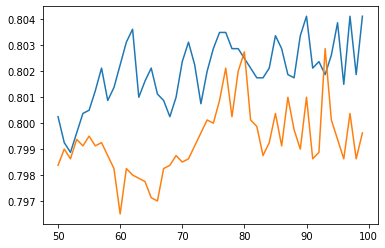

In [98]:
plt.plot(range(50,100,1), gbdtX)
plt.plot(range(50,100,1), gbdtT)

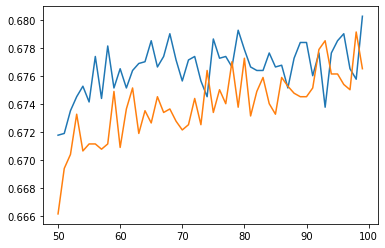

In [99]:
plt.plot(range(50,100,1), gbdtD)
plt.plot(range(50,100,1), gbdtD1)

In [116]:
X_new_mav = mat.fit_transform(X_new)
test_new_mav = mat.transform(test_new)

#X_mav_f = mat.fit_transform(X_f)
#X_mav_x2 = x2.fit_transform(X_mav, y)
#test_mav_f = mat.transform(test_f)
#test_mav_x2 = x2.transform(test_mav)
lgbX = lgb.Dataset(X_new_mav, label = (y - 1))

lgbm_params = {'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
                  'num_leaves': 90,
                  'max_depth': 10,
                  'num_class': 3,
                  'verbosity': -1}

    
#training and testing
lgb_model = lgb.train(lgbm_params, lgbX, 50)
#prediction on test
lgb_prediction = lgb_model.predict(test_new_mav)
#model predict probability, convert into classes
lgbm_prediction = np.array([np.argmax(i) for i in lgb_prediction])
lgbm_prediction = lgbm_prediction+1
lgbm_prediction = np.array(lgbm_prediction, dtype = 'float64')
lgbm_prediction

array([2., 1., 1., ..., 1., 2., 2.])

In [121]:
lgbm_prediction = np.array(lgbm_prediction, dtype = 'float64')
lgbm_prediction

array([2., 1., 1., ..., 1., 2., 2.])

In [111]:
len(lgbm_prediction)

40000

In [49]:
%%time
score = []
for k in range(1000, 1900, 100):
    mi = SelectKBest(mutual_info_classif, k = k)
    mi.fit(X_f,y)
    X_f_mi = mi.transform(X_f)
    rc.fit(X_f_mi, y)
    acc = rc.score(X_f_mi,y)
    print(k, acc)
    score.append(acc.mean())

1000 0.80335
1100 0.8049
1200 0.8063
1300 0.80785
1400 0.80875
1500 0.8098
1600 0.81105
1700 0.811575
1800 0.812375
Wall time: 9min 43s


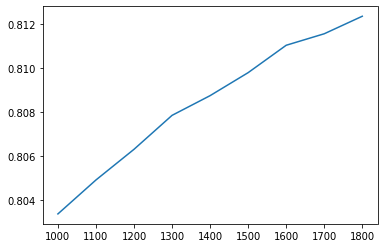

In [50]:
plt.plot(range(1000, 1900, 100), score)

In [55]:
f.fit(X_vt, y)
X_vt_f = f.transform(X_vt)
rc.fit(X_vt_f, y)
rc_f = rc.score(X_vt_f,y)

In [119]:
f.fit(X, y)
X_f = f.transform(X)
test_f = f.transform(test)
rc.fit(X_f, y)
rc_f = rc.score(X_f, y)
rc_predicted = rc.predict(test_f)
print(X_f.shape, rc_f)

(40000, 1817) 0.802875


In [30]:
x2.fit(X, y)
X_x2 = x2.transform(X)
test_x2 = x2.transform(test)
rc.fit(X_x2, y)
rc_x2 = rc.score(X_x2, y)
print(X_x2.shape, rc_x2)

(40000, 2069) 0.814825


In [36]:
mi = SelectKBest(mutual_info_classif, k = 1000)
X_mi = mi.fit_transform(X, y)
test_mi = mi.transform(test)

In [38]:
rc.fit(X_mi, y)
rc_mi = rc.score(X_mi, y)
print(X_mi.shape, rc_mi)

(40000, 1000) 0.804075


In [43]:
mi = SelectKBest(mutual_info_classif, k = 1000)
X_f_mi = mi.fit_transform(X_f, y)
test_f_mi = mi.transform(test_f)
rc.fit(X_f_mi, y)
rc_f_mi = rc.score(X_f_mi, y)
print(X_f_mi.shape, rc_f_mi)

(40000, 1000) 0.80335


In [50]:
print(X_vt_f.shape)

(40000, 734)


In [60]:
x2.fit(X_vt,y)
X_vt_x2 = x2.transform(X_vt)
test_vt_x2 = x2.transform(test_vt)
rc.fit(X_vt_x2, y)
rc_x2 = rc.score(X_vt_x2,y)
rc_x2

0.8004

In [51]:
print(X_vt_x2.shape)

(40000, 780)


In [51]:
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X,y)
lasso.score(X,y)

0.44762798568323214

In [22]:
rc_predicted=rc.predict(test_vt)

In [54]:
test_vt_f = f.transform(test_vt)
print(test_vt_f.shape)

(10000, 734)


In [31]:
rc_x2_predicted = rc.predict(test_x2)

In [74]:
rc_f_predicted = rc.predict(test_f)

In [39]:
rc_mi_predicted = rc.predict(test_mi)

In [44]:
rc_f_mi_predicted = rc.predict(test_f_mi)

In [62]:
rc_vt_x2_predicted = rc.predict(test_vt_x2)

In [68]:
rc_vt_mi_predicted = rc.predict(test_vt_mi)

In [ ]:
log_predicted = 

In [100]:
testingSet.index

RangeIndex(start=0, stop=10000, step=1)

In [82]:
pca_score = []
knn15 = KNeighborsClassifier(n_neighbors=15)
for c in range(10, 30):
    pca = PCA(n_components=c)
    D_train_pca = pca.fit_transform(D_train)
    D_test_pca = pca.transform(D_test)
    
    
    knn15.fit(D_train_pca, y_train)
    pca_score.append(knn15.score(D_test_pca, y_test))

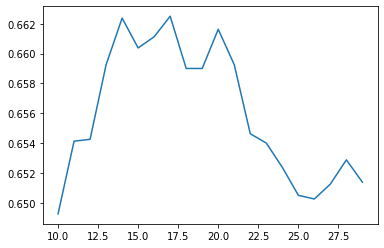

In [83]:
plt.plot(range(10, 30), pca_score)

In [91]:
pca1_score = []
knn15 = KNeighborsClassifier(n_neighbors=15)
for c in range(10, 30):
    pca = PCA(n_components=c)
    D1_train_pca = pca.fit_transform(D1_train)
    D1_test_pca = pca.transform(D1_test)
    
    
    knn15.fit(D1_train_pca, y_train)
    pca1_score.append(knn15.score(D1_test_pca, y_test))

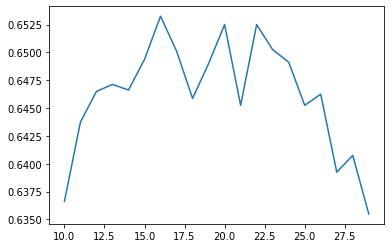

In [92]:
plt.plot(range(10, 30), pca1_score)

In [77]:
D_train_pca.shape

(32000, 9)

In [78]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D_train_pca, y_train)
knn15.score(D_test_pca, y_test)

0.645375

In [68]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D_train, y_train)
knn15.score(D_test, y_test)

0.630125

In [56]:
knn5 = KNeighborsClassifier(n_neighbors=99)
knn5.fit(D_train, Dy_train)
knn5.score(D_test, Dy_test)

0.59325

In [32]:
kscore=[]
for k in range(5, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(D1_train, D1y_train)
    acc = knn.score(D1_test, D1y_test)
    print(k, acc)
    kscore.append(acc)

5 0.62625
7 0.627625
9 0.62625
11 0.627125
13 0.626125
15 0.630125
17 0.6295
19 0.6285
21 0.627875
23 0.626625
25 0.626625
27 0.62325
29 0.625125
31 0.6235
33 0.623
35 0.622375
37 0.62225
39 0.620875
41 0.61975
43 0.61825
45 0.61575
47 0.613375
49 0.613375


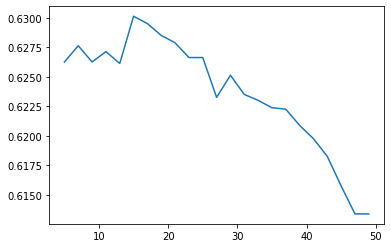

In [33]:
plt.plot(range(5, 50, 2), kscore)

In [61]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D,y)
knn15_predicted = knn15.predict(Dt)

In [64]:
knn15 = KNeighborsClassifier(n_neighbors=15)
knn15.fit(D1,y)
knn15_predicted = knn15.predict(D1t)

In [62]:
knn15_predicted

array([1., 1., 1., ..., 1., 1., 2.])

In [43]:
D_train_f = f.fit_transform(D_train, Dy_train)
D_test_f = f.transform(D_test)
print(D_train_f.shape)
knn5.fit(D_train_f, Dy_train)
print(knn5.score(D_test_f, Dy_test))

(32000, 49)
0.6205


In [35]:
scale_svm = make_pipeline(StandardScaler(),svm.LinearSVC(random_state=0, tol=1e-5, multi_class = 'crammer_singer'))
scale_svm.fit(D_train, Dy_train)
scale_svm.score(D_test, Dy_test)

0.6435

In [36]:
scale_svm.fit(D1_train, D1y_train)
scale_svm.score(D1_test, D1y_test)

0.6435

In [38]:
scale_svm.fit(X_train.todense(), y_train)
scale_svm.score(X_test.todense(), y_test)

0.774875

In [51]:
knn5 = KNeighborsClassifier(n_neighbors=201)
knn5.fit(D1_train, D1y_train)
knn5.score(D1_test, D1y_test)

0.567875

In [27]:
bgm = BayesianGaussianMixture(n_components=3, random_state=42)
bgm.fit(D_train, y = Dy_train)
bgm.score(D_test, Dy_test)

-49.98054772526579

In [28]:
bgm.predict(D_test)

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [26]:
Dy_test

6468    1.0000
18232   2.0000
2401    1.0000
33478   2.0000
10700   2.0000
11408   1.0000
9341    1.0000
6983    2.0000
12891   2.0000
27127   2.0000
24597   1.0000
23328   2.0000
3366    1.0000
17341   2.0000
25383   2.0000
20402   2.0000
37971   2.0000
39517   2.0000
35263   1.0000
28672   1.0000
16148   1.0000
11199   3.0000
15207   2.0000
7391    1.0000
13043   1.0000
804     2.0000
22049   2.0000
34996   1.0000
441     2.0000
20168   3.0000
         ...  
39815   1.0000
8712    2.0000
22274   2.0000
21197   2.0000
39533   2.0000
23634   3.0000
16350   1.0000
27145   2.0000
27338   2.0000
27340   2.0000
15709   1.0000
33132   3.0000
27957   1.0000
32478   2.0000
26306   1.0000
19587   2.0000
32358   1.0000
24244   1.0000
38754   3.0000
20548   2.0000
5550    1.0000
23659   2.0000
24744   1.0000
12466   2.0000
3073    3.0000
25868   1.0000
8417    1.0000
21958   1.0000
8886    3.0000
6657    2.0000
Name: duration_label, Length: 8000, dtype: float64

In [42]:
a = [(1,2),(3,4),(5,6)]
a[-1][-1]

6

In [41]:


classifiers = [KNeighborsClassifier(n_neighbors=15),
                KNeighborsClassifier(n_neighbors=15),
                MultinomialNB()]
Datas=[((D_train, Dy_train),(D_test, Dy_test)),((D1_train, D1y_train),(D1_test, D1y_test)),((X_train, y_train),(X_test,y_test))]


In [54]:
%%time
for Data,clf in zip(Datas,classifiers):
    trainin = Data[0]
    testin = Data[1]
    clf.fit(trainin[0],trainin[1])
    print("Accuracy:",clf.score(testin[0],testin[1]))
    

Accuracy: 0.630125
Accuracy: 0.630125
Accuracy: 0.714875
Wall time: 12 s


In [136]:
%%time
base1 = KNeighborsClassifier(n_neighbors=15)
base2 = KNeighborsClassifier(n_neighbors=15)
base3 = MultinomialNB()
metaclassifier = LogisticRegression()

base1.fit(D_train, y_train)
base2.fit(D1_train, y_train)
base3.fit(X_train, y_train)

yhats = [base1.predict(D_train),base2.predict(D1_train),base3.predict(X_train)]
print(yhats)
yhats = np.column_stack(yhats)
print(yhats.shape)
assert yhats.shape[0] == X_train.shape[0]

metaclassifier.fit(yhats, y_train)

yhats = [base1.predict(D_test),base2.predict(D1_test),base3.predict(X_test)]
print(yhats)
yhats = np.column_stack(yhats)
print(yhats.shape)
assert yhats.shape[0] == X_test.shape[0]
yhat = metaclassifier.predict(yhats)

print(accuracy_score(y_test, yhat))

[array([1., 1., 2., ..., 1., 1., 1.]), array([1., 1., 2., ..., 1., 1., 1.]), array([2., 1., 2., ..., 1., 2., 1.])]
(32000, 3)
[array([1., 2., 1., ..., 1., 3., 2.]), array([1., 1., 1., ..., 1., 3., 1.]), array([1., 2., 1., ..., 1., 3., 2.])]
(8000, 3)
0.712125
Wall time: 1min 45s


In [180]:
X_new_train_mav = mat.fit_transform(X_new_train)
X_new_test_mav = mat.transform(X_new_test)
#0.801875

#vt(0.001)?
X_train_mav = mat.fit_transform(X_train)
X_test_mav = mat.transform(X_test)
#0.80575
#0.805125 no mav
#0.80075 no vt


X_train_mav_f = f.fit_transform(X_train, y_train)
X_test_mav_f = f.transform(X_test)
#0.8045

X_train_mav_x2 = x2.fit_transform(X_train, y_train)
X_test_mav_x2 = x2.transform(X_test)
#0.8015

T_new_train_mav = mat.fit_transform(T_new_train)
T_new_test_mav = mat.transform(T_new_test)
#0.800375
#0.80075 no mav

In [205]:
steps_count = sparse.load_npz('data/train_steps_vec.npz')

In [207]:
test_count = sparse.load_npz('data/test_steps_vec.npz')

In [208]:
X_vt = vt.fit_transform(steps_count, y)
test_vt = vt.transform(test_count)

In [209]:
X_vt_mav = mat.fit_transform(X_vt)
test_vt_mav = mat.transform(test_vt)
print(test_vt.shape)

(10000, 2676)


In [227]:
%%time
estimators = [('rf', RandomForestClassifier(random_state=0)),
             ('rc', RidgeClassifierCV(alphas=[1, 10, 40, 80], cv = 5)),
             ('logreg', LogisticRegression())]

stacking = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression())
stacking.fit(T_new, y)
#stacking.score(T_new_test_mav, y_test)
stack_predicted = stacking.predict(test_new)
stack_predicted

Wall time: 7min 51s


array([3., 2., 3., ..., 1., 3., 3.])

In [216]:
stack_predicted[21]

2.0

In [222]:
(stack_predicted == true)

0       False
1        True
2        True
3        True
4       False
5        True
6       False
7        True
8        True
9       False
10      False
11       True
12      False
13      False
14      False
15      False
16       True
17      False
18      False
19      False
20      False
21       True
22       True
23      False
24       True
25      False
26      False
27       True
28       True
29      False
        ...  
9970     True
9971    False
9972    False
9973    False
9974     True
9975    False
9976    False
9977     True
9978    False
9979    False
9980     True
9981    False
9982    False
9983     True
9984     True
9985    False
9986    False
9987     True
9988     True
9989     True
9990     True
9991     True
9992    False
9993     True
9994    False
9995    False
9996     True
9997     True
9998     True
9999    False
Name: duration_label, Length: 10000, dtype: bool

In [ ]:
#0.797125 for x_vt_f

In [137]:
%%time
#stacking with countvectoriser
metaclassifier = LogisticRegression()

f.fit(X_train, y_train)
X_train_f = f.transform(X_train)
X_test_f = f.transform(X_test)

base1 = RandomForestClassifier(random_state=0)
base2 = RidgeClassifierCV(alphas=[80, 130, 260], cv = 5)

base1.fit(X_train_f, y_train)
base2.fit(X_train_f, y_train)

X_train_f_mav = mat.fit_transform(X_train_f)
X_test_f_mav = mat.transform(X_test_f)
lgbX = lgb.Dataset(X_train_f_mav, label = (y_train - 1))


lgbm_params = {'learning_rate': 0.05, 'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
                  'num_leaves': 88,
                  'max_depth': 10,
                  'num_class': 3,
                  'verbosity': -1}
base3 = lgb.train(lgbm_params, lgbX, 50)


yhats = [base1.predict(X_train_f),base2.predict(X_train_f),base3.predict(X_train_f_mav)]

#yhats = np.concatenate(yhats, axis=1)
yhats = np.column_stack(yhats)
assert yhats.shape[0] == X_train.shape[0]

metaclassifier.fit(yhats, y_train)

yhats = [base1.predict(X_test_f),base2.predict(X_test_f),base3.predict(X_test_f_mav)]

#yhats = np.concatenate(yhats, axis=1)
yhats = np.column_stack(yhats)
assert yhats.shape[0] == X_test.shape[0]
yhat = metaclassifier.predict(yhats)

print(accuracy_score(y_test, yhat))

0.797125
Wall time: 1min 50s


In [455]:
vec_stack_all_predicted_train

NameError: name 'vec_stack_all_predicted_train' is not defined

In [451]:
evaluation.evaluate_models([stack_predicted, vec_stack_all_predicted], y, titles= ['stackcount', 'stackvec'])

Evaluating stackcount:


ValueError: Found input variables with inconsistent numbers of samples: [40000, 10000]

In [437]:
metaclassifier = LogisticRegression(C = 0.01, multi_class = 'multinomial')
yhats = [stacking.predict_proba(X_f_vt_mi_mav),vec_stacking.predict_proba(X_vec)]

yhats = np.concatenate(yhats, axis=1)
#yhats = np.column_stack(yhats)

assert yhats.shape[0] == X_f_vt_mi_mav.shape[0]

metaclassifier.fit(yhats, y)

yhats = [stacking.predict_proba(test_f_vt_mi_mav),vec_stacking.predict_proba(test_vec)]

yhats = np.concatenate(yhats, axis=1)
#yhats = np.column_stack(yhats)
assert yhats.shape[0] == test_f_vt_mi_mav.shape[0]
yhat = metaclassifier.predict(yhats)

#print(accuracy_score(y_test, yhat))
         


In [326]:
C = [0.001,0.01, 0.1, 1, 10, 100]
yhat_score = []
for c in C:
    metaclassifier = LogisticRegression(C = c, multi_class = 'multinomial')
    yhats = [stacking.predict_proba(X_f_vt_mi_mav),vec_stacking.predict_proba(X_vec)]

    yhats = np.concatenate(yhats, axis=1)
    #yhats = np.column_stack(yhats)

    assert yhats.shape[0] == X_f_vt_mi_mav.shape[0]

    metaclassifier.fit(yhats, y)

    yhats = [stacking.predict_proba(test_f_vt_mi_mav),vec_stacking.predict_proba(test_vec)]

    yhats = np.concatenate(yhats, axis=1)
    #yhats = np.column_stack(yhats)
    assert yhats.shape[0] == test_f_vt_mi_mav.shape[0]
    yhat = metaclassifier.predict(yhats)
    yhat_score.append((yhat == true).sum()/10000)
    #print(accuracy_score(y_test, yhat))

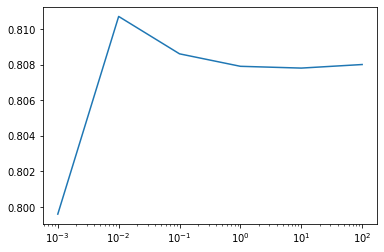

In [330]:
plt.plot(C, yhat_score)
plt.xscale('log')

In [442]:
predicted = pd.DataFrame({'id':testingSet.index+1, 'duration_label':stack_predicted})
predicted.to_csv('predicted.csv', index = False)

In [113]:
predicted

,id,duration_label
0,1,2.0000
1,2,1.0000
2,3,1.0000
3,4,1.0000
4,5,2.0000
5,6,1.0000
6,7,2.0000
7,8,1.0000
8,9,1.0000
9,10,2.0000
